# Prueba no-paramétrica: *Bootstrap*

Podemos estimar la incerteza de un estimador de forma no-paramétrica usando **muestreo tipo *bootstrap***

Esto consiste en tomar nuestro conjunto de datos de tamaño $n$ y crear $m$ nuevos conjuntos que "se le parezcan". Luego se calcula el valor del estimador que estamos buscando en los $m$ conjuntos. Con esto obtenemos una distribución para el estimador como muestra el siguiente diagrama

<img src="img/stats8.png" width="700">

Podemos responder preguntas sobre el estadístico, calcular probabilidades y/o medir intervalos de confianza utilizando la distribución obtenida con bootstrap

:::{important}

Bootstrap es un procedimiento no parámetrico pues no requiere suponer que la muestra original sigue una distribución específica (e.g. normal)

:::


Para crear los subconjuntos podríamos suponer independencia y utilizar **muestreo con reemplazo**. Esto consiste en tomar $N$ muestras al azar permitiendo repeticiones, como muestra el siguiente diagrama

<img src="img/stats7.png" width="700">

Si no es posible suponer indepedencia se puede realizar bootstrap basado en residuos y bootstrap dependiente. Puedes consultar más detalles sobre [*bootstrap*](https://www.stat.cmu.edu/~cshalizi/402/lectures/08-bootstrap/lecture-08.pdf) [aquí](http://homepage.divms.uiowa.edu/~rdecook/stat3200/notes/bootstrap_4pp.pdf) y [acá](https://www.sagepub.com/sites/default/files/upm-binaries/21122_Chapter_21.pdf)

A continuación nos enfocaremos en el clásico muestreo con reemplazo y como implementarlo en Python

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

## Implementación con Numpy y Scipy

La función [`numpy.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) permite remuestrear con repetición a partir de un ndarray

Consideremos el ejemplo del modelo de regresión lineal sobre la base de datos de consumo de helados que hemos utilizado anteriormente. En este casi debemos remuestrar las parejas/tuplas $(x_i, y_i)$

> Utilicemos bootstrap para encontrar distribuciones de $\theta_0$, $\theta_1$ y el coeficiente de correlación $r$

Para calcular los parámetros y $r$ en cada muestreo utilizamos `scipy.stats.linregress`. El resultado para una regresión de consumo versus temperatura esto sería:

In [2]:
df = pd.read_csv('../linalg/data/helados.csv', header=0, index_col=0)
df.columns = ['consumo', 'ingreso', 'precio', 'temperatura']

x, y = df["temperatura"].values, df["consumo"].values
params = scipy.stats.linregress(x, y)
np.random.seed(0)

def muestreo_con_reemplazo(x, y):
    n = len(x)
    idx = np.random.choice(n, size=n, replace=True)
    return x[idx], y[idx]

def boostrap_linregress(x, y, m):
    # Parámetros: t0, t1 y r
    params = np.zeros(shape=(m, 3)) 
    for j in range(m):
        res = scipy.stats.linregress(*muestreo_con_reemplazo(x, y))
        params[j, :] = [res.intercept, res.slope, res.rvalue]
    return params

bootstrap_params = boostrap_linregress(x, y, m=1000)

Y las distribuciones bootstrap de cada estadístico son:

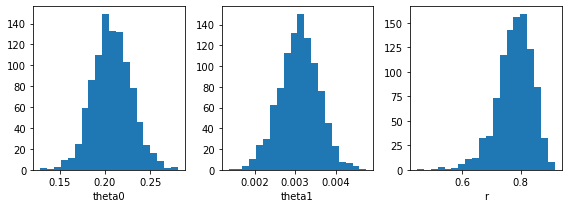

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), tight_layout=True)

for ax_, dist, name in zip(ax, bootstrap_params.T, ['theta0', 'theta1', 'r']):
    ax_.hist(dist, bins=20)
    ax_.set_xlabel(name)

## Intervalos de confianza empíricos

Veamos más en detalle la distribución empírica de $r$ obtenida usando bootstrap

En la figura de abajo tenemos

- Linea roja: valor de $r$ con la muestra original
- Lineas punteadas negras: Intervalo de confianza empírico al 95%

Podemos calcular facilmente el intervalo de confianza de en un arreglo utilizando [`np.percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html?highlight=percentile#numpy.percentile)


In [4]:
r_bootstrap = boostrap_params[:, 2]
IC = np.percentile(r_bootstrap, [2.5, 97.5])

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
hist_val, hist_lim, _ = ax.hist(r_bootstrap, bins=20, density=True)
ax.plot([params.rvalue]*2, [0, np.max(hist_val)], 'r-', lw=2)
ax.plot([IC[0]]*2, [0, np.max(hist_val)], 'k--', lw=2)
ax.plot([IC[1]]*2, [0, np.max(hist_val)], 'k--', lw=2)

print(f"Intervalo de confianza al 95% de r: {IC}")

NameError: name 'boostrap_params' is not defined

De la figura podemos notar que el 95% de la distribución empírica esta sobre $r=0.5$

:::{note}

La distribución empírica de $r$ no es simétrica. Por lo tanto aplicar un t-test parámetrico sobre $r$ no hubiera sido correcto (se quiebra el supuesto de normalidad)

:::

## Visualizando la incerteza del modelo

Usando la distribución empírica de los parámetros $\theta_0$ y $\theta_1$ podemos visualizar la incerteza de nuestro modelo de regresión lineal

En la figura de abajo tenemos
- Puntos azules: Datos
- Linea roja: Modelo de regresión lineal en los datos
- Sombra rojo claro: $\pm 2$ desviaciones estándar del modelo en base a la distribución empírica

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.set_ylabel('Consumo')
ax.set_xlabel('Temperatura')
ax.scatter(x, y, zorder=100, s=10, label='datos')

def model(theta0, theta1, x):
    return x*theta1 + theta0

ax.plot(x_plot, model(params.intercept, params.slope, x_plot),
        c='r', lw=2, label='mejor ajuste')

dist_lines = model(boostrap_params[:, 0], boostrap_params[:, 1], x_plot.reshape(-1, 1)).T
mean_lines, std_lines = np.mean(dist_lines, axis=0), np.std(dist_lines, axis=0)
ax.fill_between(x_plot, 
                mean_lines - 2*std_lines,
                mean_lines + 2*std_lines, 
                color='r', alpha=0.25, label='incerteza')
plt.legend();